# Логичтическая регрессия, метод опорных векторов, one-hot кодирование

### О задании

В этом задании вы изучите методы работы с категориальными переменными

In [1]:
%pylab inline
import pandas as pd

from sklearn.base import BaseEstimator
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split

Populating the interactive namespace from numpy and matplotlib


__Задание 1.__ Обучение логистической регрессии на реальных данных и оценка качества классификации.

**(2 балла)**


Загрузим данные с конкурса [Kaggle Porto Seguro’s Safe Driver Prediction](https://www.kaggle.com/c/porto-seguro-safe-driver-prediction) (вам нужна только обучающая выборка). Задача состоит в определении водителей, которые в ближайший год воспользуются своей автомобильной страховкой (бинарная классификация). Но для нас важна будет не сама задача, а только её данные. При этом под нужды задания мы немного модифицируем датасет.

In [2]:
import pandas as pd
data = pd.read_csv('train.csv', index_col=0)
target = data.target.values
data = data.drop('target', axis=1)

Пересемплируем выборку так, чтобы положительных и отрицательных объектов в выборке было одинаковое число. Разделим на обучающую и тестовую выборки.

In [3]:
from sklearn.model_selection import train_test_split
np.random.seed(910)
mask_plus = np.random.choice(np.where(target == 1)[0], 100000, replace=True)
mask_zero = np.random.choice(np.where(target == 0)[0], 100000, replace=True)

Не забудьте отнормировать признаки (можно воспользоваться StandardScaler или сделать это вручную). Пока не будем обращать внимание на то, что некоторые признаки категориальные (этим мы займёмся позже).

In [4]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

data = pd.concat((data.iloc[mask_plus], data.iloc[mask_zero]))
target = np.hstack((target[mask_plus], target[mask_zero]))

scaler = StandardScaler()
data[:] = scaler.fit_transform(data).astype('float64')

# print(data)

X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.5)

C:\Users\user\AppData\Local\Temp\ipykernel_24096\1615652714.py:7: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-9.90591364e-01 -9.90591364e-01  8.84892559e-04 ...  8.84892559e-04
 -9.90591364e-01  9.92361149e-01]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  data[:] = scaler.fit_transform(data).astype('float64')
C:\Users\user\AppData\Local\Temp\ipykernel_24096\1615652714.py:7: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0.93925278 -0.54350479 -0.54350479 ... -0.54350479  0.93925278
 -0.54350479]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  data[:] = scaler.fit_transform(data).astype('float64')
C:\Users\user\AppData\Local\Temp\ipykernel_24096\1615652714.py:7: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future 

Обучите логистическую регрессию с удобными для вас параметрами, примените регуляризацию, найдтие оптимум. Сделайте предсказание на тестовой части выборки. Замерьте качество.

In [5]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [6]:
C_values = [0.01, 0.1, 1, 10, 100]

best_accuracy = 0
best_model = None
best_C = None

for C in C_values:
    model = LogisticRegression(C=C, penalty='l2', solver='lbfgs', max_iter=100)
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"C={C} => acc = {accuracy:.4f}")

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model = model
        best_C = C

C=0.01 => acc = 0.5881
C=0.1 => acc = 0.5878
C=1 => acc = 0.5879
C=10 => acc = 0.5879
C=100 => acc = 0.5879


In [7]:
print(f"Best C: {best_C}\n Acc: {best_accuracy:.4f}")
print(classification_report(y_test, best_model.predict(X_test)))

Best C: 0.01
 Acc: 0.5881
              precision    recall  f1-score   support

           0       0.58      0.63      0.60     49994
           1       0.60      0.55      0.57     50006

    accuracy                           0.59    100000
   macro avg       0.59      0.59      0.59    100000
weighted avg       0.59      0.59      0.59    100000



__Выводы__ в свободной форме:
#### Качество чуть лучше, чем угадывание рандомно

__Задание 2.__ Изучение влияния регуляризатора на процесс обучения

__(2 балла)__

Проверьте на практике, как влияет регуляризатор на процесс обучения (убывание функции потерь на обучающей и отложенной выборках). Чтобы считать функцию потерь на отложенной выборке после каждой итерации, запускайте процесс обучения логистической регрессии с параметром $max\_iter=1$ и $w^{(0)}$, полученным на предыдущей итерации. Постройте два графика: на одном из них логистическая регрессия с коэффициентом регуляризации, равным 0, а на другом с некоторым разумным значением. На каждом графике одновременно должна быть и функция потерь для обучающей, и для тестовой выборки. Не забудьте сделать одинаковыми оси обоих графиков. Какие выводы вы можете сделать?

In [32]:
from IPython.display import clear_output
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)

import matplotlib.pyplot as plt
from sklearn.metrics import log_loss

num_iter = 50  

model_none = LogisticRegression(
    penalty=None,  
    max_iter=1,
    warm_start=True,
    random_state=42
)

model_l2 = LogisticRegression(
    penalty='l2',
    C=1,     
    max_iter=1,
    warm_start=True,
    random_state=42
)

loss_train_none, loss_test_none = [], []
loss_train_l2,   loss_test_l2   = [], []

In [33]:
for i in range(num_iter):
    print(f'Epoch {i+1}/{num_iter}')
    
    model_none.fit(X_train, y_train)
    p_train_none = model_none.predict_proba(X_train)
    p_test_none  = model_none.predict_proba(X_test)

    # print(p_train_none, y_train)
    # print(p_test_none)
    
    loss_train_none.append(log_loss(y_train, p_train_none))
    loss_test_none.append(log_loss(y_test, p_test_none))
    
    model_l2.fit(X_train, y_train)
    p_train_l2 = model_l2.predict_proba(X_train)
    p_test_l2  = model_l2.predict_proba(X_test)
    loss_train_l2.append(log_loss(y_train, p_train_l2))
    loss_test_l2.append(log_loss(y_test, p_test_l2))

clear_output()

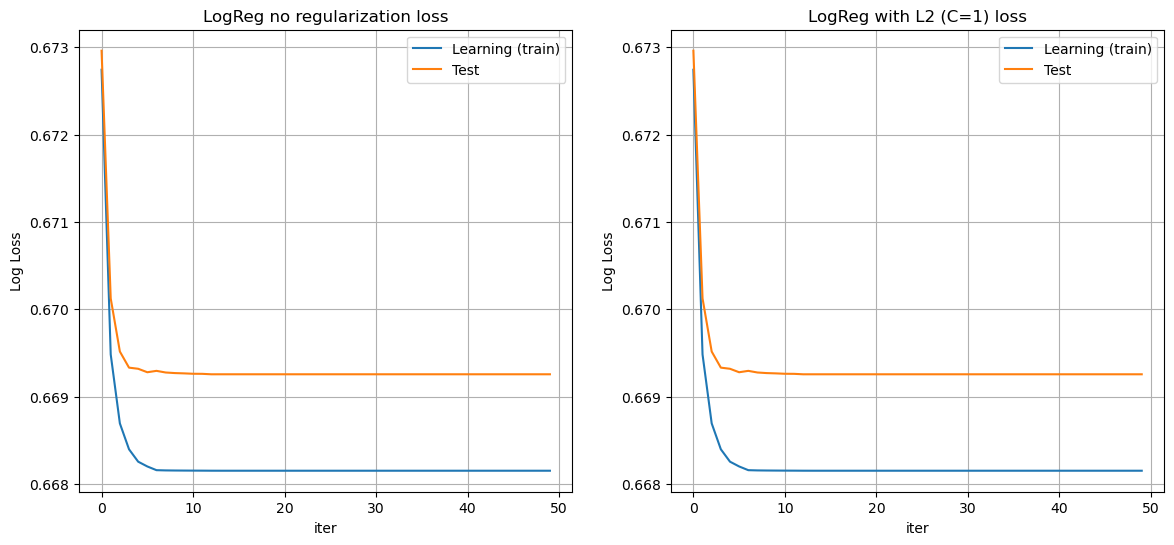

In [35]:
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(range(num_iter), loss_train_none, label='Learning (train)')
plt.plot(range(num_iter), loss_test_none, label='Test')
plt.title('LogReg no regularization loss')
plt.xlabel('iter')
plt.ylabel('Log Loss')
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(range(num_iter), loss_train_l2, label='Learning (train)')
plt.plot(range(num_iter), loss_test_l2, label='Test')
plt.title('LogReg with L2 (C=1) loss')
plt.xlabel('iter')
plt.ylabel('Log Loss')
plt.legend()
plt.grid()

plt.show()

__Выводы:__ разница меньше 1%

## Часть 2. Работа с категориальными переменными

В этой части мы научимся обрабатывать категориальные переменные, так как закодировать их в виде чисел недостаточно (это задаёт некоторый порядок, которого на категориальных переменных может и не быть). Существует два основных способа обработки категориальных значений:
- One-hot-кодирование
- Счётчики (CTR, mean-target кодирование, ...) — каждый категориальный признак заменяется на среднее значение целевой переменной по всем объектам, имеющим одинаковое значение в этом признаке.

Начнём с one-hot-кодирования. Допустим наш категориальный признак $f_j(x)$ принимает значения из множества $C=\{c_1, \dots, c_m\}$. Заменим его на $m$ бинарных признаков $b_1(x), \dots, b_m(x)$, каждый из которых является индикатором одного из возможных категориальных значений:
$$
b_i(x) = [f_j(x) = c_i]
$$

__Задание 1.__ Закодируйте все категориальные признаки с помощью one-hot-кодирования. Обучите логистическую регрессию и посмотрите, как изменилось качество модели (с тем, что было ранее). Измерьте время, потребовавшееся на обучение модели.

__(3 балла)__

In [16]:
def train_and_evaluate(X_encoded, y):
    X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)
    model = LogisticRegression(max_iter=1000)
    start_time = time.time()
    model.fit(X_train, y_train)
    training_time = time.time() - start_time
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    return training_time, accuracy

In [17]:
import pandas as pd
import time
from sklearn.base import BaseEstimator
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

data = pd.read_csv("train.csv")

X = data.drop(columns=["target"])
y = data["target"]

categorical_features = [col for col in X.columns if "_cat" in col]

encoder = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')
X_encoded = encoder.fit_transform(X[categorical_features])
X_encoded = pd.DataFrame(X_encoded, columns=encoder.get_feature_names_out())

X = X.drop(columns=categorical_features)
X = pd.concat([X, X_encoded], axis=1)
print("One-hot is done!")

training_time, accuracy = train_and_evaluate(X, y)

print(f"Learning time: {training_time:.4f} seconds")
print(f"Accuracy: {accuracy:.4f}")

One-hot is done!
Learning time: 131.1585 seconds
Accuracy: 0.9632


Как можно было заменить, one-hot-кодирование может сильно увеличивать количество признаков в датасете, что сказывается на памяти, особенно, если некоторый признак имеет большое количество значений. Эту проблему решает другой способ кодирование категориальных признаков — счётчики. Основная идея в том, что нам важны не сами категории, а значения целевой переменной, которые имеют объекты этой категории. Каждый категориальный признак мы заменим средним значением целевой переменной по всем объектам этой же категории:
$$
g_j(x, X) = \frac{\sum_{i=1}^{l} [f_j(x) = f_j(x_i)][y_i = +1]}{\sum_{i=1}^{l} [f_j(x) = f_j(x_i)]}
$$

__Задание 2.__ Закодируйте категориальные переменные с помощью счётчиков (ровно так, как описано выше без каких-либо хитростей). Обучите логистическую регрессию и посмотрите на качество модели на тестовом множестве. Сравните время обучения с предыдущим экспериментов. Заметили ли вы что-то интересное?

__(2 балла)__

In [19]:
import pandas as pd
import time
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

data = pd.read_csv("train.csv")

X = data.drop(columns=["target"])
y = data["target"]

categorical_features = [col for col in X.columns if "_cat" in col]

def mean_target_encoding(df, cat_features, target):
    encoded_df = df.copy()
    for col in cat_features:
        means = df.groupby(col)[target].transform('mean')
        encoded_df[col] = means
    return encoded_df

X_encoded = mean_target_encoding(pd.concat([X, y], axis=1), categorical_features, "target")
X_encoded = X_encoded.drop(columns=categorical_features)
print("Mean encoding is done!")

training_time, accuracy = train_and_evaluate(X_encoded, y)

print(f"Learning time: {training_time:.4f} seconds")
print(f"Accuracy: {accuracy:.4f}")

Mean encoding is done!
Learning time: 35.7058 seconds
Accuracy: 1.0000


__Вывод:__ точность стала явно выше (сомневаюсь, что правда 1, но в любом случае явно лучше, чем забивая на категориальные переменные)

Отметим, что такие признаки сами по себе являются классификаторами и, обучаясь на них, мы допускаем "утечку" целевой переменной в признаки. Это ведёт к переобучению, поэтому считать такие признаки необходимо таким образом, чтобы при вычислении для конкретного объекта его целевая метка не использовалась. Это можно делать следующими способами:
- вычислять значение счётчика по всем объектам расположенным выше в датасете (например, если у нас выборка отсортирована по времени)
- вычислять по фолдам, то есть делить выборку на некоторое количество частей и подсчитывать значение признаков по всем фолдам кроме текущего (как делается в кросс-валидации)
- внесение некоторого шума в посчитанные признаки (необходимо соблюсти баланс между избавление от переобучения и полезностью признаков).

__Задание 3.__ Реализуйте корректное вычисление счётчиков двумя из трех вышеперчисленных способов, сравните. Снова обучите логистическую регрессию, оцените качество. Сделайте выводы.

__(3 балла)__

In [24]:
import pandas as pd
import time
import numpy as np
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

data = pd.read_csv("train.csv")

X = data.drop(columns=["target"])
y = data["target"]

categorical_features = [col for col in X.columns if "_cat" in col]

# k-fold
def mean_target_encoding_kfold(df, cat_features, target, n_splits=5):
    encoded_df = df.copy()
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    for col in cat_features:
        encoded_df[col] = 0.0
        for train_idx, val_idx in kf.split(df):
            train_fold, val_fold = df.iloc[train_idx], df.iloc[val_idx]
            means = train_fold.groupby(col)[target].mean()
            encoded_df.loc[val_idx, col] = val_fold[col].map(means).astype(float)
    return encoded_df

# add noise
def mean_target_encoding_noisy(df, cat_features, target, noise_level=0.01):
    encoded_df = df.copy()
    for col in cat_features:
        means = df.groupby(col)[target].transform('mean')
        noise = np.random.normal(0, noise_level, size=means.shape)
        encoded_df[col] = means + noise
    return encoded_df

X_kfold = mean_target_encoding_kfold(pd.concat([X, y], axis=1), categorical_features, "target")
print("KFold is done!")
X_noisy = mean_target_encoding_noisy(pd.concat([X, y], axis=1), categorical_features, "target")
print("Noisy is done!")

X_kfold = X_kfold.drop(columns=categorical_features)
X_noisy = X_noisy.drop(columns=categorical_features)


training_time_kfold, accuracy_kfold = train_and_evaluate(X_kfold, y)
training_time_noisy, accuracy_noisy = train_and_evaluate(X_noisy, y)

print(f"KFold method -  Learning time: {training_time_kfold:.4f} seconds, Accuracy: {accuracy_kfold:.4f}")
print(f"Noisy method - Learning time: {training_time_noisy:.4f} seconds, Accuracy: {accuracy_noisy:.4f}")

KFold is done!
Noisy is done!
KFold method -  Learning time: 36.5480 seconds, Accuracy: 1.0000
Noisy method - Learning time: 34.4499 seconds, Accuracy: 1.0000


__Вывод:__ точность особо не поменялась, но подозреваю, что она была бы выше